In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import nltk
from tqdm import tqdm

In [63]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

In [64]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [65]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [66]:
true['category'] = 1
false['category'] = 0

In [67]:
df = pd.concat([true,false])

In [69]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [70]:
df.shape

(44898, 5)

In [71]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [73]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Since the topics in subject column are different for real and fake, we will not use it for training.

In [75]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

## Text Preprocessing

In [ ]:
import bs4
from bs4 import BeautifulSoup
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
lemma = WordNetLemmatizer()

In [76]:


# initialize a variable to contain stopwords in English
stop_words = set(stopwords.words('english')) 
punctuation = list(string.punctuation)
stop_words.update(punctuation)

def cleaner(original_tweet):
     
    # converting all characters to lowercase
    original_tweet = str(original_tweet).lower()
    
    soup = BeautifulSoup(original_tweet, "html.parser")
    original_tweet = soup.get_text()
    
    original_tweet = re.sub('\[[^]]*\]', '', original_tweet) # removing square brackets 
    original_tweet = re.sub(r'http\S+', '', original_tweet) # removing URL's
      
    # tokenization
    original_tweet = word_tokenize(original_tweet)
    
    #removing stop words
    original_tweet = [word for word in original_tweet if word not in stop_words]
    
    return " ".join(original_tweet)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [77]:
df['text'] = df['text'].apply(lambda text: cleaner(text))
df.head()

,text,category
0,washington reuters head conservative republica...,1
1,washington reuters transgender people allowed ...,1
2,washington reuters special counsel investigati...,1
3,washington reuters trump campaign adviser geor...,1
4,seattle/washington reuters president donald tr...,1


WORDCLOUD FOR True TEXT 

In [19]:
plt.figure(figsize = (20,20))
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

WORDCLOUD FOR FAKE TEXT 

In [20]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      44898 non-null  object
 1   category  44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


### Naive Bayes 

In [78]:
# Finally, we will transform the data into occurrences, 
# 
from sklearn.feature_extraction.text import CountVectorizer

# This converts the list of words into space-separated strings
# data['text'] = data['text'].apply(lambda x: ' '.join(x))

count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['text'])
# We could leave it as the simple word-count per message, but it is better to use Term Frequency Inverse Document Frequency, more known as tf-idf
# 
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts)

counts = transformer.transform(counts)

from sklearn.model_selection import train_test_split

# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(counts, df['category'], test_size=0.2, random_state=82)

from sklearn.naive_bayes import MultinomialNB

# modelling using the Multinomial Naive Bayes model
model = MultinomialNB().fit(X_train, y_train)

# predicting using test set
predicted = model.predict(X_test)
print(np.mean(predicted == y_test)) 

0.942761692650334


## Glove Vector Embeddings

In [79]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(df['text'],df['category'].values,test_size=0.2,shuffle=True,random_state=82) 

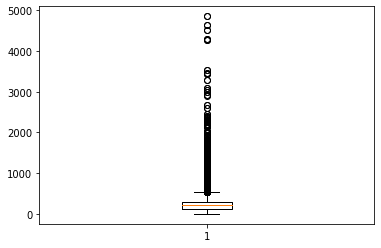

In [26]:
df['text_length']=df['text'].apply(lambda text: len(text))
maximum = df['text_length'].max()
plt.boxplot(df['text_length'])
plt.show()

In [82]:
x_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) 
x_tokenizer.fit_on_texts(x_train)
tokenized_train = x_tokenizer.texts_to_sequences(x_train)
x_train = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train, maxlen=300)

In [84]:
tokenized_test = x_tokenizer.texts_to_sequences(x_valid)
x_valid = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test, maxlen=300)

In [35]:
x_word_index = x_tokenizer.word_index

In [36]:
len(x_word_index)

190955

In [92]:
EMBEDDING_FILE = '../input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = x_tokenizer.word_index
nb_words = min(10000, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= 10000: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [94]:
learning_rate_reduction =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 100, input_length=300, weights=[embedding_matrix], trainable=False),
#     tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(128,recurrent_dropout = 0.1 , dropout = 0.1, return_sequences = True),
    tf.keras.layers.LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

num_epochs = 10

history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_valid, y_valid), verbose=1,batch_size=256,callbacks = [learning_rate_reduction])
model.save('lstm_glove.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 1,168,241
Trainable params: 168,241
Non-trainable params: 1,000,000
_________________________________________________________________
Epoch 1/10
141/141 [==============================] - 367s 3s/step - loss: 0.2414 - accuracy: 0.8808 - v

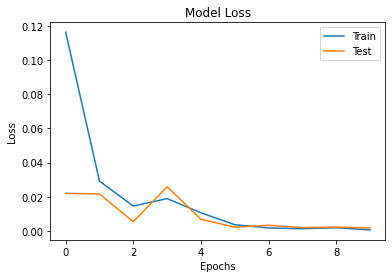

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

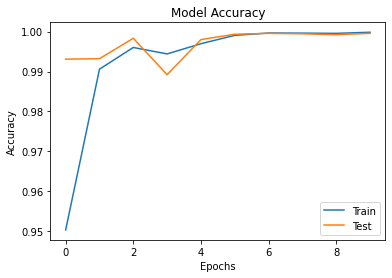

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.show()